In [9]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import datetime
import seaborn as sns
from functions import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [2]:
# Github does not accept files above 100mb and test.csv is 104mb
# thus we upload zip whith test.csv which needs to be extracted
with zipfile.ZipFile("../data/test.csv.zip","r") as zip_ref:
    zip_ref.extractall("../data/")

In [3]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [4]:
#Lets verify loaded data
print(y.shape)
print(tX.shape)
print(ids.shape)

print(y)
print(tX)
print(ids)

(250000,)
(250000, 30)
(250000,)
[ 1. -1. -1. ...,  1. -1. -1.]
[[ 138.47    51.655   97.827 ...,    1.24    -2.475  113.497]
 [ 160.937   68.768  103.235 ..., -999.    -999.      46.226]
 [-999.     162.172  125.953 ..., -999.    -999.      44.251]
 ..., 
 [ 105.457   60.526   75.839 ..., -999.    -999.      41.992]
 [  94.951   19.362   68.812 ..., -999.    -999.       0.   ]
 [-999.      72.756   70.831 ..., -999.    -999.       0.   ]]
[100000 100001 100002 ..., 349997 349998 349999]


In [6]:
weights = np.zeros((tX.shape[1],1))
weights.shape

(30, 1)

In [12]:
tX[:,0]

array([ 138.47 ,  160.937, -999.   , ...,  105.457,   94.951, -999.   ])

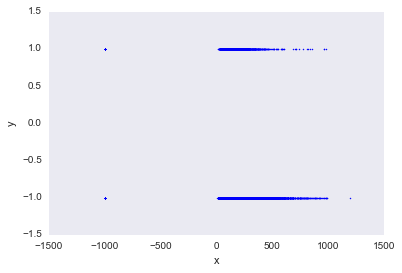

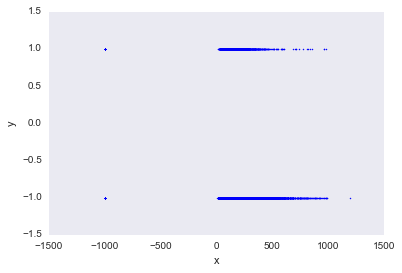

In [18]:
fig = plt.figure()

ax2 = fig.add_subplot(1, 1, 1)
ax2.scatter(tX[:,0].T, y, marker=".", color='b', s=5)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.grid()
fig

# Do your thing crazy machine learning thing here :) ...

In [ ]:
#Lets test some basics: Least Squares Gradient Descent
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 1
gamma = 0.4

# Initialization
w_initial = weights

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = least_squares_GD(y, tX, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download test data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '../data/submission.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [20]:
# Delete train.csv such that github accepts push
os.remove('../data/test.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/test.csv'